In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_columns', 100)
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
import datetime
import calendar
from tqdm import tqdm_notebook as tqdm

from collections import Counter

from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from numba import jit
from itertools import product
import copy

In [56]:
%%time
BASE_PATH = '/input/data-science-bowl-2019'
train = pd.read_csv(BASE_PATH + '/train.csv')
train_labels = pd.read_csv(BASE_PATH + '/train_labels.csv')
test = pd.read_csv(BASE_PATH + '/test.csv')
specs = pd.read_csv(BASE_PATH + '/specs.csv')
submission = pd.read_csv(BASE_PATH + '/sample_submission.csv')

Wall time: 57.2 s


In [3]:
print(train.shape)
train.head()

(11341042, 11)


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [4]:
keep_id = train[train.type == 'Assessment']['installation_id'].drop_duplicates()
train = train[train['installation_id'].isin(keep_id)]

In [5]:
print(train.shape)

(8294138, 11)


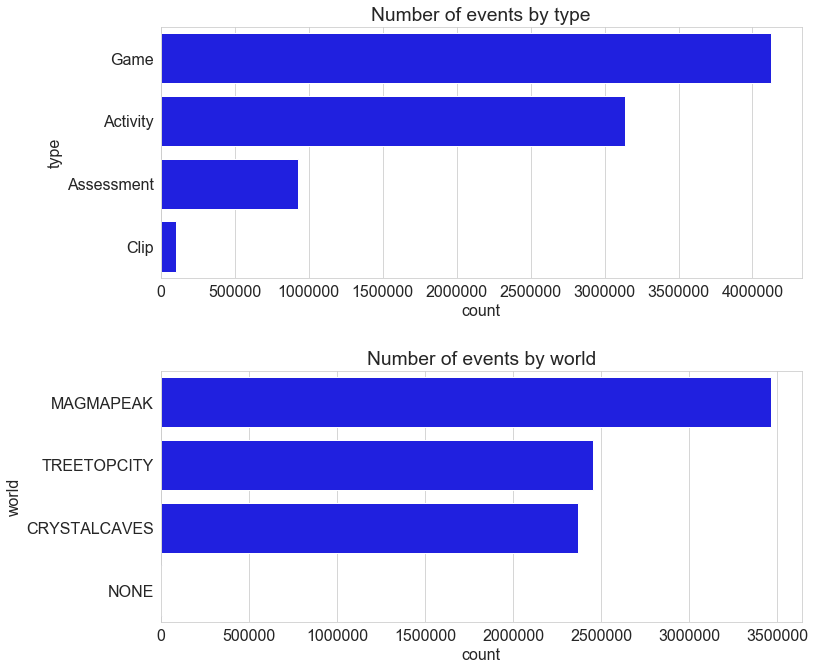

In [6]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(211)
ax1 = sns.countplot(y='type', data=train, color='blue', order=train.type.value_counts().index)
plt.title('Number of events by type')

ax2 = fig.add_subplot(212)
ax2 = sns.countplot(y='world', data=train, color='blue', order=train.world.value_counts().index)
plt.title('Number of events by world')

plt.tight_layout(pad=2)
plt.show()

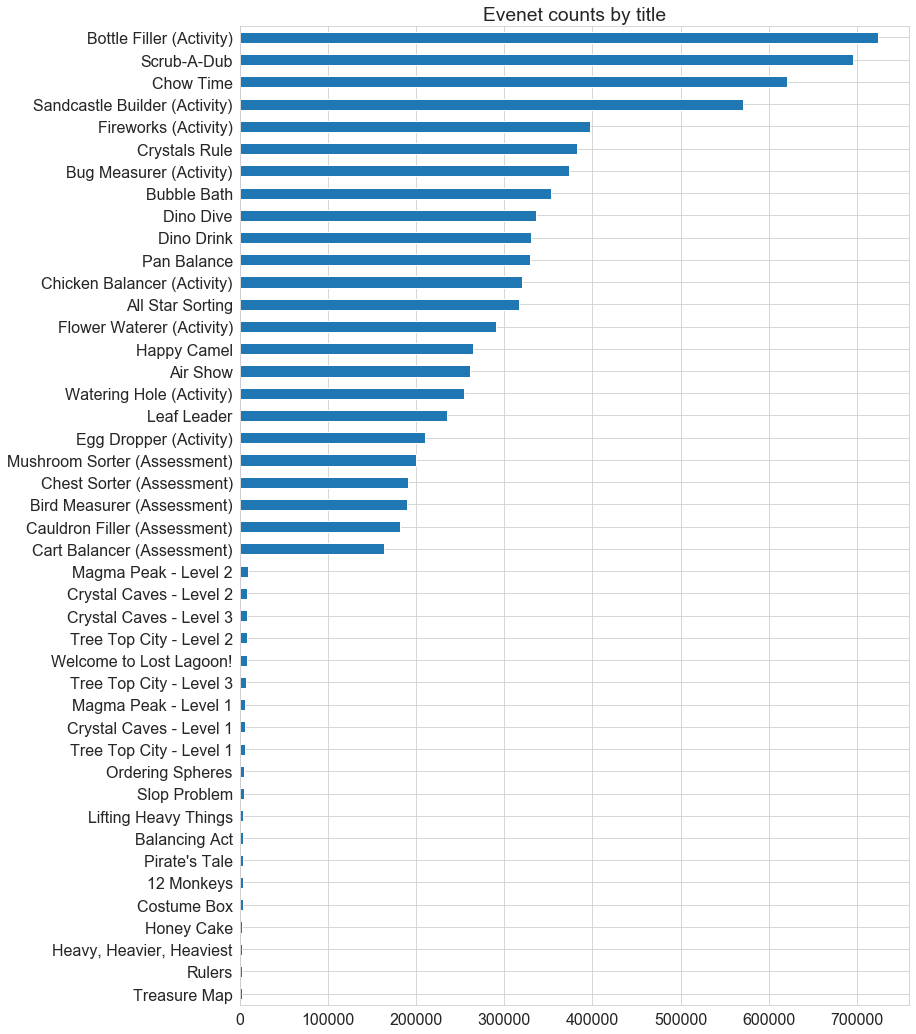

In [7]:
fig = plt.figure(figsize=(12, 18))
train.title.value_counts().sort_values(ascending=True).plot.barh()
plt.title('Evenet counts by title')
plt.show()

In [8]:
def get_time(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    return df

train = get_time(train)

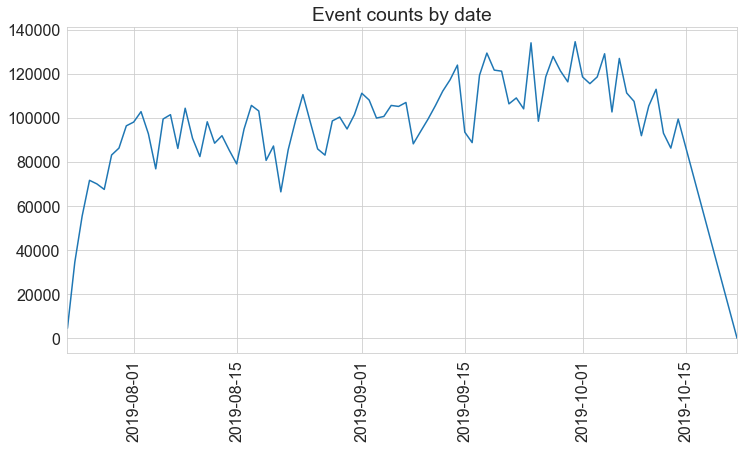

In [9]:
fig = plt.figure(figsize=(12, 6))
train.date.value_counts().plot()
plt.title('Event counts by date')
plt.xticks(rotation=90)
plt.show()

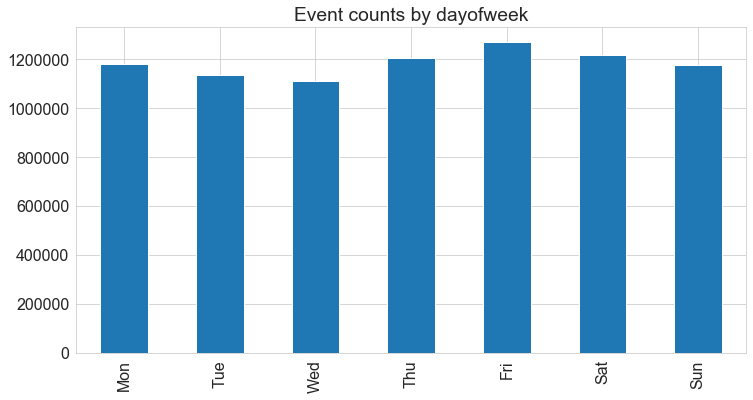

In [10]:
fig = plt.figure(figsize=(12, 6))
se = train.groupby('dayofweek')['dayofweek'].count()
se.index = list(calendar.day_abbr)
se.plot.bar()
plt.title('Event counts by dayofweek')
plt.show()

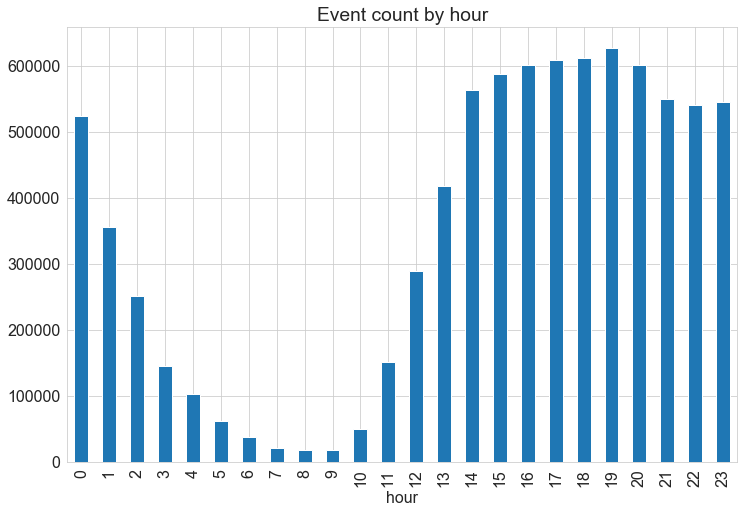

In [11]:
fig = plt.figure(figsize=(12, 8))
train.groupby('hour')['hour'].count().plot.bar()

plt.title('Event count by hour')
plt.xticks(rotation=90)
plt.show()

In [12]:
print(test.shape)
test.head()

(1156414, 11)


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


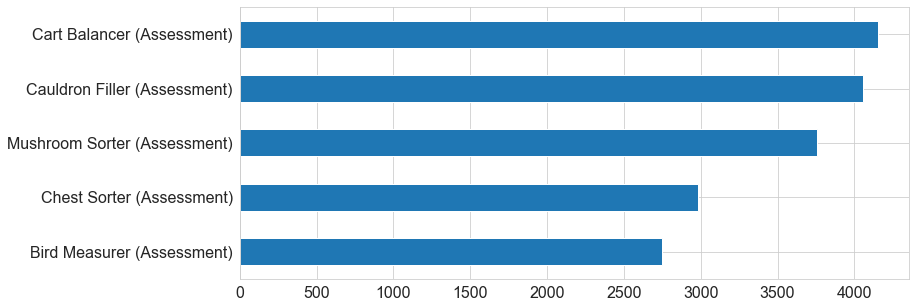

In [13]:
fig = plt.figure(figsize=(12, 5))
train_labels.title.value_counts().sort_values().plot.barh()
plt.show()

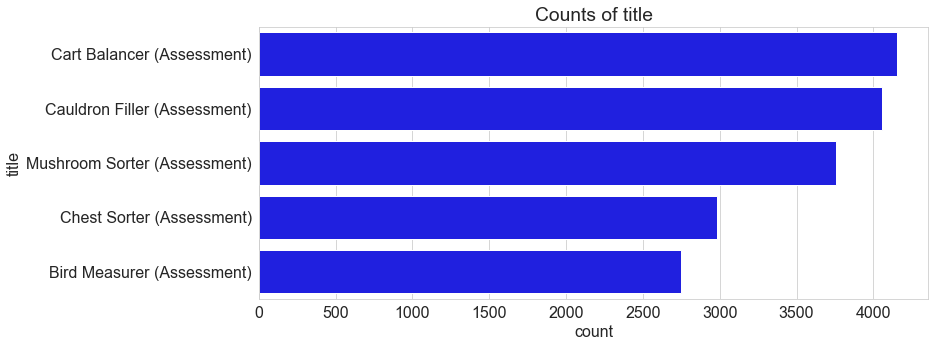

In [14]:
fig = plt.figure(figsize=(12, 5))
sns.countplot(y='title', data=train_labels, color='blue', order=train_labels.title.value_counts().index)
plt.title('Counts of title')
plt.show()

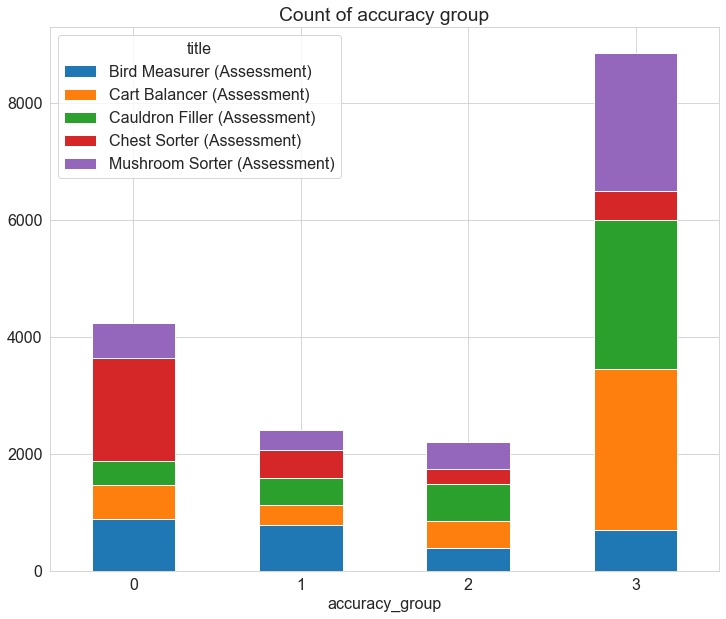

In [15]:
train_labels.groupby(['title', 'accuracy_group'])['accuracy_group'] \
    .count() \
    .unstack('title') \
    .plot.bar(stacked=True, rot=0, figsize=(12, 10), title='Count of accuracy group')
plt.show()

In [16]:
train[~train['installation_id'].isin(train_labels['installation_id'].unique())]['installation_id'].nunique()

628

In [17]:
train = train[train['installation_id'].isin(train_labels['installation_id'].unique())]
train.shape

(7734558, 15)

In [18]:
print(f'Number of rows in train_labels: {train_labels.shape[0]}')
print(f'Number of unique game_sessions in train_labels: {train_labels.game_session.nunique()}')

Number of rows in train_labels: 17690
Number of unique game_sessions in train_labels: 17690


In [19]:
train = train.drop(['date', 'month', 'hour', 'dayofweek'], axis=1)

In [20]:
train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
all_title_event_code = list(set(train['title_event_code'].unique()).union(test['title_event_code'].unique()))
list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
list_of_world = list(set(train['world'].unique()).union(set(test['world'].unique())))

activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
activities_world = dict(zip(list_of_world, np.arange(len(list_of_world))))
assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index)
                     .union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))

train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)
train['world'] = train['world'].map(activities_world)
test['world'] = test['world'].map(activities_world)
train_labels['title'] = train_labels['title'].map(activities_map)

win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [37]:
def get_data(user_sample, test_set=False):
    last_activity = 0
    user_activities_count = {'Clip': 0, 'Activity': 0, 'Assessment': 0, 'Game': 0}

    time_spent_each_act = {actv: 0 for actv in list_of_user_activities}
    event_code_count = {eve: 0 for eve in list_of_event_code}
    last_session_time_sec = 0

    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []

    for i, session in user_sample.groupby('game_session', sort=False):
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]

        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1]/1000)
            time_spent_each_act[activities_labels[session_title]] += time_spent

        if (session_type == 'Assessment') & (test_set or len(session)>1):
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()

            features = user_activities_count.copy()
            features.update(time_spent_each_act.copy())
            features.update(event_code_count.copy())
            features['installation_id'] = session['installation_id'].iloc[-1]
            features['session_title'] = session['title'].iloc[0]
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts

            accumulated_correct_attempts += true_attempts
            accumulated_uncorrect_attempts += false_attempts

            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session['timestamp'].iloc[-1] - session['timestamp'].iloc[0]).seconds)

            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0

            accuracy = true_attempts/(true_attempts + false_attempts) if (true_attempts + false_attempts) != 0  else 0
            accumulated_accuracy += accuracy

            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1

            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1

            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            features['accumulated_actions'] = accumulated_actions
            
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)

            counter += 1

        n_of_event_codes = Counter(session['event_code'])
        
        for key in n_of_event_codes.keys():
            event_code_count[key] += n_of_event_codes[key]

        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activity = session_type

    if test_set:
        return all_assessments[-1]

    return all_assessments

In [38]:
sample_id = train[train.installation_id == '0006a69f']
sample_id_data = get_data(sample_id)
sample_df = pd.DataFrame(sample_id_data)
sample_df

,Clip,Activity,Assessment,Game,Tree Top City - Level 3,Bubble Bath,Dino Drink,Chicken Balancer (Activity),Tree Top City - Level 2,12 Monkeys,Magma Peak - Level 2,Crystal Caves - Level 1,Pan Balance,Dino Dive,Lifting Heavy Things,Tree Top City - Level 1,Air Show,Flower Waterer (Activity),Mushroom Sorter (Assessment),Bottle Filler (Activity),Cauldron Filler (Assessment),Pirate's Tale,Crystal Caves - Level 3,Ordering Spheres,Costume Box,Bird Measurer (Assessment),Chest Sorter (Assessment),Egg Dropper (Activity),Crystals Rule,Treasure Map,Magma Peak - Level 1,Balancing Act,Sandcastle Builder (Activity),Happy Camel,Cart Balancer (Assessment),Crystal Caves - Level 2,All Star Sorting,Rulers,Fireworks (Activity),Leaf Leader,Honey Cake,Watering Hole (Activity),"Heavy, Heavier, Heaviest",Slop Problem,Welcome to Lost Lagoon!,Bug Measurer (Activity),Chow Time,Scrub-A-Dub,2050,4100,...,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,installation_id,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,6,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,164,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89,0,0,0,163,0,91,0,0,0,0,0,0,0,0,115,6,0,...,0,4,1,2,77,7,9,0,0,0,0,0,4,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,0006a69f,14,0,0,0.00,0.0,3,0,0,0,0,0.0,647
1,8,4,1,4,0,0,0,0,0,0,0,0,0,0,0,0,193,164,0,0,0,0,0,0,0,0,0,0,78,0,0,0,89,0,0,0,163,0,91,0,0,0,0,0,0,104,0,115,6,5,...,0,4,1,2,223,11,16,0,0,0,0,0,6,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,0006a69f,21,1,0,39.00,1.0,0,0,0,0,1,3.0,1143
2,8,4,2,4,0,0,0,0,0,0,0,0,0,0,0,0,193,164,0,0,0,0,0,0,0,0,0,0,78,0,0,0,89,0,0,0,163,0,91,0,0,0,0,0,0,104,0,115,6,5,...,0,4,1,2,225,22,16,0,0,0,0,0,6,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,0006a69f,14,1,11,65.50,0.5,3,1,0,0,1,1.5,1230
3,15,9,3,7,0,133,110,0,0,0,0,0,0,0,0,0,193,254,0,165,0,0,0,0,0,0,0,0,78,0,0,0,126,0,0,0,229,0,1611,0,0,80,0,0,0,104,0,195,9,6,...,0,8,2,5,336,25,40,9,0,5,0,5,10,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,1,0006a69f,14,2,11,41.25,0.5,2,2,0,0,2,1.5,2159
4,17,10,3,9,0,133,110,0,0,0,0,0,0,0,0,0,336,254,0,165,0,0,0,0,0,0,0,0,310,0,0,0,126,0,0,0,229,0,1611,0,0,80,0,0,0,184,0,195,9,12,...,1,8,2,5,457,30,53,9,0,5,0,5,12,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,1,0006a69f,21,3,12,39.20,0.5,3,2,0,1,2,1.6,2586


In [39]:
compiled_data = []
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)),
                                     total=train.installation_id.nunique(),
                                     desc='Installation_id',
                                     position=0):
    compiled_data += get_data(user_sample)

In [40]:
reduce_train = pd.DataFrame(compiled_data)
del compiled_data
reduce_train.shape

(17690, 103)

In [41]:
new_test = []
for i, (ins_id, user_sample) in tqdm(enumerate(test.groupby('installation_id', sort=False)),
                                     total=test.installation_id.nunique(),
                                     desc='Installation_id',
                                     position=0
                                    ):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)

reduce_test = pd.DataFrame(new_test)    

In [42]:
reduce_test.shape

(1000, 103)

In [43]:
reduce_test.head()

,Clip,Activity,Assessment,Game,Tree Top City - Level 3,Bubble Bath,Dino Drink,Chicken Balancer (Activity),Tree Top City - Level 2,12 Monkeys,Magma Peak - Level 2,Crystal Caves - Level 1,Pan Balance,Dino Dive,Lifting Heavy Things,Tree Top City - Level 1,Air Show,Flower Waterer (Activity),Mushroom Sorter (Assessment),Bottle Filler (Activity),Cauldron Filler (Assessment),Pirate's Tale,Crystal Caves - Level 3,Ordering Spheres,Costume Box,Bird Measurer (Assessment),Chest Sorter (Assessment),Egg Dropper (Activity),Crystals Rule,Treasure Map,Magma Peak - Level 1,Balancing Act,Sandcastle Builder (Activity),Happy Camel,Cart Balancer (Assessment),Crystal Caves - Level 2,All Star Sorting,Rulers,Fireworks (Activity),Leaf Leader,Honey Cake,Watering Hole (Activity),"Heavy, Heavier, Heaviest",Slop Problem,Welcome to Lost Lagoon!,Bug Measurer (Activity),Chow Time,Scrub-A-Dub,2050,4100,...,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,installation_id,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,5,3,1,3,0,0,0,0,0,0,0,0,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,88,0,0,0,0,90,0,0,0,1960,0,194,0,0,0,0,0,0,33,135,0,0,1,...,0,0,0,0,108,33,9,0,0,0,0,0,3,120,12,0,10,148,0,111,33,0,33,9,0,25,0,1,11,190,1,7,0,0,0,0,0,00abaee7,16,1,0,30.0,1.000000,0,0,0,0,1,3.0,867
1,16,11,5,11,0,96,159,108,0,0,0,0,129,155,0,0,123,178,0,348,0,0,0,0,0,0,0,317,169,0,0,0,334,181,0,0,64,0,173,67,0,73,0,0,0,74,110,162,6,23,...,3,10,2,7,416,25,72,9,0,4,0,4,12,325,26,36,94,407,11,418,49,25,25,72,6,57,0,4,85,385,2,80,0,2,6,2,0,01242218,30,4,7,49.6,0.466667,0,1,1,2,1,1.6,2718
2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,24,0,0,0,0,0,0,0,0,15,0,20,4,40,0,24,0,0,0,0,0,8,0,0,0,14,0,0,0,0,0,0,0,017c5718,14,0,0,0.0,0.000000,0,0,0,0,0,0.0,149
3,4,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77,0,25,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,21,2,3,0,0,0,0,0,1,31,0,29,9,61,0,21,0,0,2,3,0,13,0,0,3,28,2,3,0,0,0,1,0,01a44906,14,0,0,0.0,0.000000,0,0,0,0,0,0.0,233
4,5,1,0,4,0,0,0,221,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,155,0,0,610,0,0,0,0,0,0,0,0,0,218,0,0,0,...,0,1,0,1,73,27,27,0,0,0,0,0,6,146,0,3,0,231,0,75,62,16,27,27,4,24,0,0,28,134,9,25,0,0,0,0,5,01bc6cb6,30,0,0,0.0,0.000000,0,0,0,0,0,0.0,951


In [46]:
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby('installation_id')['Clip'].transform('count')
        df['installation_duration_time'] = df.groupby('installation_id')['duration_mean'].transform('mean')
        df['installation_title_nunique'] = df.groupby('installation_id')['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2000, 3010, 4070, 3110, 4030, 4021, 4020,
                                         4090, 4010, 2080, 2081, 2020, 2040, 2030,
                                         3021, 3121, 2050, 3020, 3120, 2083, 2025,
                                         4035, 4025, 4022, 2035, 4040, 4100, 2010,
                                         2060, 2070, 4110, 5000, 5010, 4031, 4045,
                                         4095, 4220, 2075, 4230, 4235, 4080, 4050]].sum(axis=1)
        df['installation_event_code_count_mean'] = df.groupby('installation_id')['sum_event_code_count'].transform('mean')        
        
        features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns
        
        features = [x for x in features if x not in['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]
        
    return reduce_train, reduce_test, features
    
reduce_train, reduce_test, features = preprocess(reduce_train, reduce_test)        

In [47]:
params = {'n_estimators': 2000,
          'boostin_type': 'gdbt',
          'objective': 'regression',
          'metric': 'rmse',
          'subsample': 0.75,
          'subsample': 1,
          'learning': 0.04,
          'feature_fraction': 0.9,
          'max_depth': 15,
          'lambda_l1': 1,
          'lambda_l2': 1,
          'verbose': 100,
          'early_stopping_rounds': 100,
          'eval_metric': 'cappa'
         }

In [48]:
y = reduce_train['accuracy_group']

In [52]:
n_fold = 5
folds = GroupKFold(n_splits=n_fold)

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True

In [7]:
class LGBWrapper_regr(object):
    def __init__(self):
        self.model = lgb.LGBMRegessor()
    
    def fit(self, X_train, y_train, X_valid, y_valid, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'
        
        eval_set = [(X_train, y_train)]
        eval_name = ['train']
        self.model = self.model.set_params(**params)
        
        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('Valid')
            
        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')
        
        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'
            
        self.model.fit(X=X_train, y=y_train, eval_set=eval_set,
                       eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'],
                       early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns
                      )
        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_
    
    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)
    
def eval_qwk_xgb(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = y_pred.argmax(axis=1)
    return 'cappa', -qwk(y_true, y_pred)

class LGBWrapper(object):
    def __init__(self):
        self.model = lgb.LGBMClassifier()
    
    def fit(self, X_train, y_train, X_valid, y_valid, X_holdout=None, y_holdout=None, params=None):
        eval_set = [(X_train, y_train)]
        eval_name = ['train']
        self.model = model.get_params(**params)
        
        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_name.append('valid')
            
        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_name.append('holdout')
        
        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.colums]
            
            if len(cat_cols) > 0:
                categorical_columns = params['cat_columns']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'
        
        self.model = model.fit(X=X_train, y=y_train, eval_set=eval_set,
                               eval_names=eval_names, eval_metric=eval_metric,
                               verbose=params['verbose'],
                               early_stopping_rounds=params['early_stopping_rounds'],
                               categorical_feature=cetegorical_columns
                              )
        self.base_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_
        
    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)
        
class CatWrapper(object):
    def __init__(self):
        self.model = cat.CatBoostClassifier()
    
    def fit(self, X_train, y_train, X_valid, y_valid, X_holdout=None, y_holdout=None, params=None):
        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**{k: v for k, v in params.items() if k != 'cat_columns'})
        
        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
        
        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            
        if 'cat_cols' in params.keys():
            cat_cols = [col for col in 'cat_cols' if col in X_train.columns]
            
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = None
        else:
            categorical_columns = None
        
        self.model = self.model.fit(X=X_train, y=y_train, eval_set=eval_set,
                                    verbose=params['verbose'],
                                    early_stopping_rounds=params['early_stopping_rounds'],
                                    categrical_features=catgorical_columns
                                   )
        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_
        
    def predict_proba(self, X_test):
        if 'MultiClass' not in self.model.get_params('loss_function'):
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)
        
class XGBClassifier(object):
    def __init__(self):
        self.model = xgb.XGBClassifier()
        
    def fit(self, X_train, y_train, X_valid, y_valid, X_holdout=None, y_holdout=None, params=None):
        eval_set =[(X_train, y_train)]
        self.model = self.model.set_params(**params)
        
        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
        
        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            
        self.model.fit(X=X_train, y=y_train, eval_set=eval_set,
                       eval_metrics=evql_qwk_xgb,
                       verbose=params['verbose'],
                       early_stopping_rounds=params['early_stopping_rounds']
                      )

        scores = self.model.best_score_
        self.best_scores_ = {k: {m: m_v[-1] for m, m_v in v.items()} for k, v in scores.items()}
        self.best_scores_ = {k: {m: n if m != 'cappa' else -n for m, n in v.items()} for k, v in self.best_score_items()}
        
        self.feature_importaces = self.model.feature_importances
        
    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration_)
        
        
class MainTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, convert_cyclical: bool=False, create_interactions: bool=False, n_interactions=20):
        
        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions
        
    def fit(self, X, y=None):
        
        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            
            return self
        
    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)    
            
            return data
        
    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)
                        
class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [ ]:
class RegressorModel(object):
    def __init__(self, columns: list=None, model_wrapper=None):
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None
        
    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame=None, y_holdout=None,
            folds=None,
            params: dict=None,
            eval_metric='rmse',
            cols_to_drop: list=None,
            preprocesser=None,
            transformers: dict=None,
            adversarial: bool=False,
            plot: bool=True):
        
        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True
        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target
        
        X = X[self.columns]
        if X_hlodout is not None:
            X_holdout = X_holdout[self.columns]
        
        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = sel.fpreprocesser.transform(X_holdout)
                
        for fold_n, (train_index, valid_index) in numerate(folds.split(X, y, X['installation_id'])):
            
            if X_holdout is not None:
                X_hold = X_hold.copy()
            else:
                X_hold = None
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}
            
            X_train, X_valid = X.iloc[train_index], X.iloc[valid.index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid.index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None
                
            datasets = {}
            